In [2]:
import time
import copy
import warnings
from collections import defaultdict, deque
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print('Device name:', torch.cuda.get_device_name())

# Load MNIST data

In [14]:
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load train and validation set
dataset = datasets.CIFAR10('./data', download=True, train=True, transform=transform)
train_set, val_set = data.random_split(dataset, [40000, 10000])  # split into train and val set

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
# load test set
test_set = datasets.CIFAR10('./data', download=True, train=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
print(f"Number of training images: {len(train_set)}")
print(f"Number of validation images: {len(val_set)}")
print(f"Number of testing images: {len(test_set)}")
print(f"Size of each image: {train_set[0][0].size()}")
data_loader = {'train': train_loader, 'val': val_loader}

Number of training images: 40000
Number of validation images: 10000
Number of testing images: 10000
Size of each image: torch.Size([3, 32, 32])


## Show some images

In [11]:
def imshow(img, ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

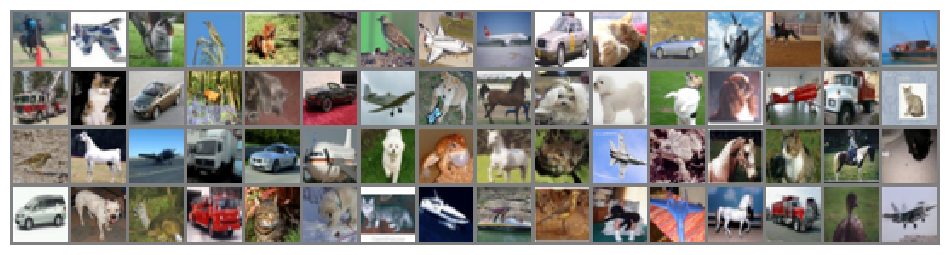

In [16]:
# get some random training images
data_iter = iter(data_loader['train'])
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(BATCH_SIZE/4))
imshow(grid, ax=ax)

In [17]:
# classes
categories = dataset.class_to_idx
output_size = len(categories)
categories

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

# Convoluational Neural Network

In [22]:
class CNN(nn.Module):
    def __init__(self, output_size=output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
# test network
cnn(torch.rand(1, 3, 32, 32))

tensor([[-0.0846,  0.0944,  0.0179,  0.0171,  0.0138, -0.1053,  0.0686,  0.0864,
          0.1246,  0.0503]], grad_fn=<AddmmBackward>)

# Train the network

In [27]:
def train(model, data_loader, epochs=5, lr=1e-2, momentum=0.9):
    model.__init__()  # reset model weights
    model = model.to(device)
    # define training function
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    # define loss function
    criterion = nn.CrossEntropyLoss()
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = defaultdict(lambda: deque(maxlen=epochs))
    accuracy_history = defaultdict(lambda: deque(maxlen=epochs))

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 60)    

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # make predictions
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs.data, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                total += labels.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_history[phase].append(epoch_loss)
            accuracy_history[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
            

    time_elapsed = time.time() - since
    print('-' * 60)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.3f} %'.format(100 * best_acc))
    print('=' * 60, '\n')
    # load best weights
    model.load_state_dict(best_weights)
    return loss_history, accuracy_history

In [28]:
loss_history, accuracy_history = train(cnn, data_loader, epochs=5)

Epoch 1/5
------------------------------------------------------------
train Loss: 1.9034 Acc: 0.2959
val Loss: 1.5734 Acc: 0.4302
Epoch 2/5
------------------------------------------------------------
train Loss: 1.4649 Acc: 0.4626
val Loss: 1.4069 Acc: 0.4947
Epoch 3/5
------------------------------------------------------------
train Loss: 1.3246 Acc: 0.5214
val Loss: 1.3405 Acc: 0.5270
Epoch 4/5
------------------------------------------------------------
train Loss: 1.2279 Acc: 0.5602
val Loss: 1.2284 Acc: 0.5666
Epoch 5/5
------------------------------------------------------------
train Loss: 1.1347 Acc: 0.5972
val Loss: 1.2433 Acc: 0.5653
------------------------------------------------------------
Training complete in 1m 25s
Best val Acc: 56.660 %



# Visualize training performance

In [29]:
def plot_learning_curve(loss_history, accuracy_history, figsize=(12, 4)):

    x_values = range(1, len(loss_history['train'])+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharex=True)
    lines = dict(train='--', val='-')

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax1.plot(x_values, loss_history[phase], lines[phase],  label=f"{label}")

    plt.sca(ax1)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Loss")

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax2.plot(x_values, accuracy_history[phase], lines[phase], label=f"{label}")

    plt.sca(ax2)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Accuracy")
    _ = plt.suptitle(f"Training Performance\n")
    _ = plt.subplots_adjust(top=0.9)
    plt.show()

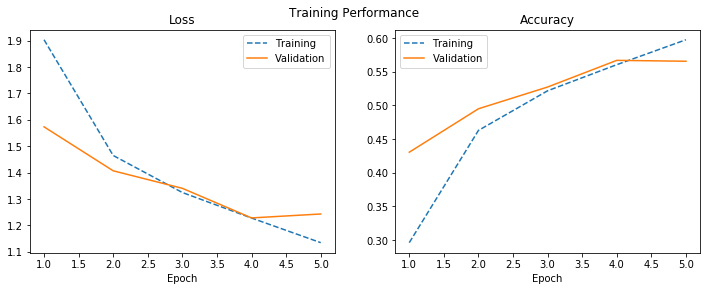

In [30]:
plot_learning_curve(loss_history, accuracy_history)

# Evaluate model

In [31]:
# convert dataset ids to classes
idx_to_class = {v:k for k,v in categories.items()}
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def plot_confusion_matrix(y_true, y_pred, labels, normalize=None, 
                          title='Confusion matrix', cmap=plt.cm.Blues, ax=None):
    """
    Function to plot confusion matrix.
    Adapted from: https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/metrics/_plot/confusion_matrix.py#L119
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp = disp.plot(cmap=cmap, ax=ax)
    _ = disp.ax_.set_title(title)
    disp.ax_.grid(False)
    return disp.ax_


def predict(model, test_loader):
    """Function to predict test data"""
    correct, total = 0, 0
    targets = []
    predictions = []

    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
        
            total += labels.size(0)
            correct += (predicted ==labels).sum().item()
            # append labels
            targets.extend(labels.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())

    score = correct / total
    targets = [idx_to_class[i] for i in targets]
    predictions = [idx_to_class[i] for i in predictions]
    return score, targets, predictions

In [34]:
# make test predictions
score, y_true, y_pred = predict(cnn, test_loader)

In [35]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 57.01 %


In [36]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    airplane       0.69      0.58      0.63      1000
  automobile       0.73      0.68      0.71      1000
        bird       0.52      0.34      0.41      1000
         cat       0.35      0.53      0.42      1000
        deer       0.47      0.48      0.48      1000
         dog       0.48      0.49      0.48      1000
        frog       0.68      0.61      0.65      1000
       horse       0.61      0.64      0.63      1000
        ship       0.68      0.66      0.67      1000
       truck       0.61      0.69      0.64      1000

    accuracy                           0.57     10000
   macro avg       0.58      0.57      0.57     10000
weighted avg       0.58      0.57      0.57     10000




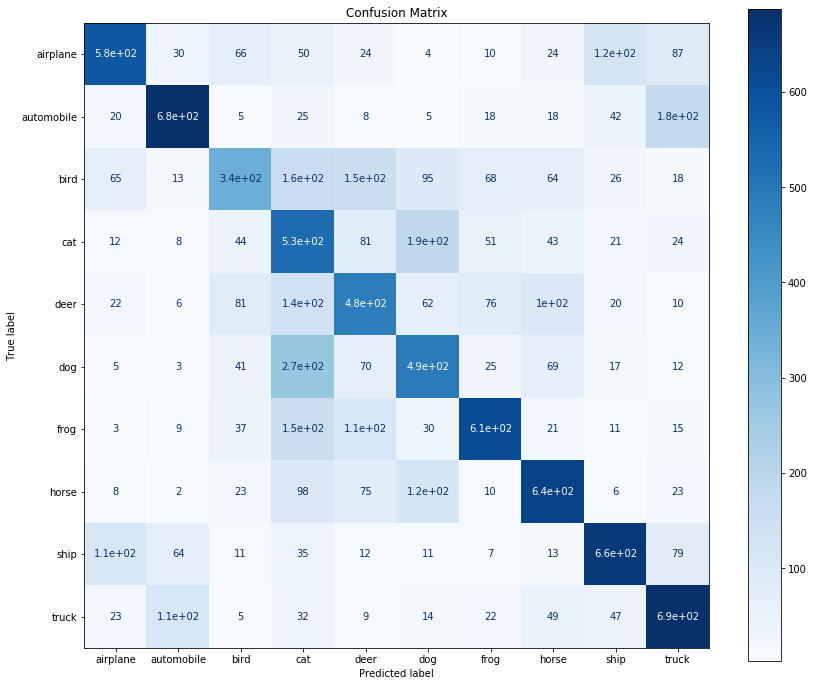

In [37]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [38]:
# save model
torch.save({
    'state_dict': cnn.state_dict(),
    'idx_to_class': idx_to_class,
}, './cifar10_cnn.pth')

In [40]:
!ls -lh cifar10_cnn.pth

-rw-r--r--  1 philip  staff   244K  7 Jun 14:38 cifar10_cnn.pth
